In [3]:
# Execute this cell first

# plotting imports
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

# display imports
from IPython.display import display, IFrame
from IPython.core.display import HTML

# for playing videos, customize height and width if desired
# keep a 16:9 ratio, e.g. 960 by 540, or 1280 by 720
def play_video(vid_name, w=640, h=360):
    vid_path = "https://media.uwex.edu/content/ds/ds775_r19/" + vid_name + "/index.html"
    hlink = '<a href = ' + vid_path + ' target = """_blank""">Open video in new tab</a>'
    display(IFrame(vid_path, width=w, height=h))
    display(HTML(hlink))

from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.datasets import load_iris
from sklearn.metrics import confusion_matrix

from skopt.plots import plot_convergence
from skopt import gp_minimize
from scipy.optimize import minimize_scalar, dual_annealing

from warnings import catch_warnings, simplefilter, filterwarnings
import numpy as np
import pandas as pd
import json
from simanneal import Annealer

# Lesson 06: Global Optimization 1

This week we're going to continue our exploration of global optimization by looking at two global optimization algorithms:  Simulated Annealing and Bayesian Optimization.

# Global Optimization

The goal of global optimization is to find the global optimal value which means we want to identify the best possible solution in the entire search space.  However, for many problems the search space is too large and/or the function landscape is too complicated to guarantee that the best solution can be found.

A metaheuristic algorithm attempts to find a good solution without any guarantee of being able to find the best solution.  Often metaheuristics are stochastic in nature, that is they incorporate randomness as an element of the search, but they aren't generally completely random in nature.  They incorporate search patterns which are known to work well for the problem at hand.

Metaheuristic algorithms try to find a compromise somewhere between randomly searching the search space and local search.  People speak of the **exploration and exploitation tradeoff**.  Exploration ensures the algorithm reaches different promising regions of the search space, whereas exploitation ensures the searching of optimal solutions within the given region.  The trick is in finding the right balance. Go too far into exploitation and the algorithm gets stuck in local extrema, go too far to exploration and the algorithm will waste time on solutions that are less likely to be good and ignore the information already gathered.

Unfortunately, there is no single algorithm which works best for all classes of problems.  This is often referred to as a "no free lunch theorem" in optimization.  In this lesson, we focus on Simulated Annealing and Bayesian Optimization.

# Simulated Annealing

Think of simulated annealing as an enhanced local search that allows some moves that don't improve the best function value to try to climb

In a hill-climbing local search we only allow moves that increase the objective function value.

Here is our pseudo-code from the previous lesson for **Local Search:**
```
 set starting state 
 while local_condition 
     select a move 
     if acceptable 
         do the move 
         if new optimum 
             remember it 
 endwhile 
 ```

Simulated annealing is a trajectory based method for generating a sequence of solutions and is similar our basic "hill-climbing" local search algorithm.  In a strict hill-climbing algorithm we only allow uphill moves, but in simulated move we sometimes allow downhill moves and are more likely to allow downhill moves in the early part of the search.  The idea is that to find the tallest peak in a mountain range we have to first descend from a lower peak.

The probability of a downhill move is determined by a temperature parameter that decreases throughout the search.  The probability of a downhill move depends on the size of the downhill move compared to the temperature.  At high temperatures large and small downhill moves are probable, but as the temperature decreases only small downhill moves are probable so that the search performs similarly to a local search at low temperatures

In simulated annealing algorithm high temperature promotes exploration (global search) while low temperature promote exploitation (local search).  As the algorithm proceeds, the temperature decreases and transitions from exploration to exploitation.

Here is pseudocode for **Simulated Annealing:**
```
 set starting state and initial temperature
 while local_condition 
     select a move 
     if acceptable 
         do the move 
         if new optimum or random # < probability determined by temperature
             remember it
     decrease temperature
 endwhile 
 ```
 
Choosing the initial temperature and the manner in which the temperature decreases are critical to the performance of simulated annealing.  We'll start with a temperature schedule that looks like this:
$$ T = T_0 \alpha^n.$$
Where $T_0$ is the initial temperature, $0 < \alpha < 1,$ and $n$ is the number of iterations.   This is called geometric temperature decay, but many other choices are possible.  However, there aren't really rules for how to choose $T_0$ and $\alpha$.  Usually we'll choose $T_0$ to be similar to the size of the function to be optimized when it is evaluated at random points and $\alpha$ should be close to $1$ like $\alpha = 0.99$.  You may have to experiment with the values of these parameters to achieve good results.  The simanneal package introduced below includes some automatic tuning of the temperature schedule that seems to work well for many problems, but it can be much slower than setting a fixed schedule for some problems.

In the next section we'll demonstrate simulated annealing using our own code for the traveling salesman problem, but in general we'll use the `simanneal` package that will be introduced further below.

# Simulated Annealing with TSP (video)

We'll use the seven city example TSP from the textbook. Find the shortest tour (or cheapest cost) to visit all 7 cities and return to the starting city in the following graph:

<img src="./images/HillierTSP.png" width=400>

We'll store all the intercity distances in a two-dimensional list that we call distance_matrix. For cities that aren't connected we'll use the "bigM" method and introduce a distance of 100 between those pairs of cities so that those routes won't be included in the tour. Note that the picture labels the cities 1 through 7, but in Python we'll use 0 through 6.  The data is stored in the included json file.

If you want to really understand how simulated annealing works, the following video includes a walkthrough of the code below.

**IMPORTANT NOTE (9/23/2023):  I say something backward in the video below when discussing (around 2:20) what to do if delta is positive or negative.  If delta is positive that means the new tour is shorter so we should always accept it, if delta is negative the new tour is longer so compute a probability to see if you accept the longer tour.  (Thanks for discovering this, Anton.)**

In [4]:
# execute this cell for video
play_video("ds775_lesson5_simulated-anneal-tsp")

In [5]:
# load data (this may have to be adapted for different problems)
with open("data/HillierTSP.json", "r") as tsp_data:
    tsp = json.load(tsp_data)
distance_matrix = tsp["DistanceMatrix"]
individual_size = tsp["TourSize"]

# define objective function
def tour_distance(individual, dist_mat):
    distance = dist_mat[individual[-1]][individual[0]]
    for gene1, gene2 in zip(individual[0:-1], individual[1:]):
        distance += dist_mat[gene1][gene2]
    return distance

def sub_tour_reversal(tour):
    # reverse a random tour segment
    num_cities = len(tour)
    i, j = np.sort(np.random.choice(num_cities, 2, replace=False))
    return np.concatenate((tour[0:i], tour[j:-num_cities + i - 1:-1],
                              tour[j + 1:num_cities]))

# Random Number Seed
# if you want reproducible results, then uncomment the following line
# and play with the seed value until you get a result you like. If you run 
# it again with the same value, then you'll get the same result.
# np.random.seed(123)

def simanneal_tsp(init_state, dist_mat, max_no_improve, init_temp, alpha): ###
    '''
    We use state to refer to the values of the input variable(s) for the objective function.
    For the TSP problem, the state is a tour of the cities.
    We use obj to refer to the objective function value.
    For the TSP problem, obj is the total distance of the tour.
    
    To adapt this for another minimization problem, 
    only the lines with tour_distance and sub_tour_reversal need to change 
    to give a different objective function and a different move function.
    Additional arguments to the objective function should be passed into the search function
    similar to how we passed in dist_mat abov
    '''

    curr_state = init_state
    curr_obj = tour_distance(curr_state, dist_mat) 
    best_state = curr_state  ###
    best_obj = curr_obj  ###

    # stop search if no better state is found within max_no_improve iterations
    num_moves_no_improve = 0
    iterations = 0
    temp = init_temp

    # save history for plotting after optimization
    history = np.array([[iterations, curr_obj, best_obj]])  ###

    while (num_moves_no_improve < max_no_improve):
        num_moves_no_improve += 1
        iterations += 1  # just for tracking
        new_state = sub_tour_reversal(curr_state) # make a move 
        new_obj = tour_distance(new_state, dist_mat)
        delta = curr_obj - new_obj ###
        prob = np.exp(min(delta, 0) / temp) ### # compute prob accept uphill move

        if new_obj < curr_obj or np.random.uniform() < prob : ### # accept if decrease or rand < prob
            curr_state = new_state
            curr_obj = new_obj
            if curr_obj < best_obj: ### # keep track of best ever
                best_state = curr_state ###
                best_obj = curr_obj ###
                num_moves_no_improve = 0 ###

        temp *= alpha ###

        history = np.vstack( (history, np.array([[iterations,curr_obj,best_obj]]) ) ) ###

    return best_state, best_obj, iterations, history

# apply the simanneal_tsp() function to our seven city problem
num_cities = len(distance_matrix)
init_tour = np.random.permutation(np.arange(num_cities))

best_tour, best_dist, iterations, history = simanneal_tsp(init_tour, distance_matrix, 200, 100, .995)
best_dist

63

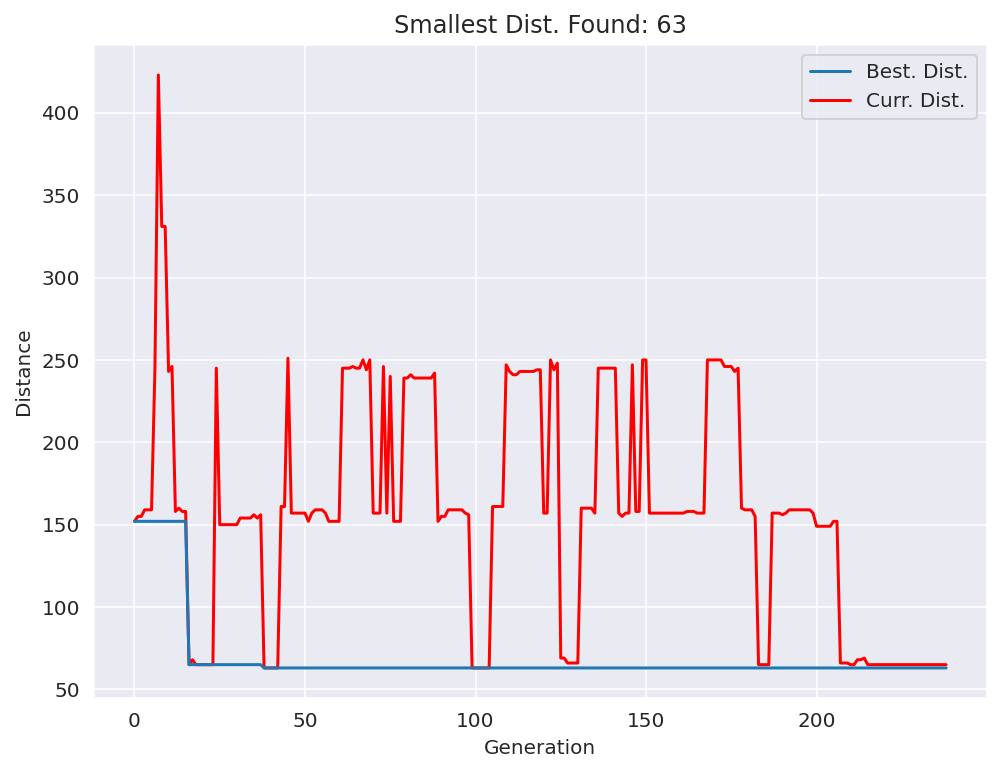

In [7]:
# plot the progress of the search for visualization
# it isn't necessary to do this in the homework, but you're welcome to do so

fig = plt.figure(figsize=(8, 6))
line_min, = plt.plot(history[:,0], history[:,1], label='Curr. Dist.',color='red')
line_curr, = plt.plot(history[:,0],history[:,2], label='Best. Dist.')
plt.xlabel('Generation')
plt.ylabel('Distance')
plt.legend(handles=[line_curr, line_min])
plt.title('Smallest Dist. Found: {:d}'.format(int(best_dist)));

### *Self Assessment: Simulated Annealing for Value Balancing*

Revisit the Value Balancing Problem introduced in Lesson 5 (it's the next-to-last section in the lesson).  Start with the local search code that is included in the self-assessment solutions and adapt it to do simulated annealing for the Value Balancing problem.  First try it on the four item problem and then see how it performs on the 1000 item problem.  Do you get good solutions?

In [8]:
# code for generating 1000 items to be balanced into 4 groups
np.random.seed(123)

tot_num_items = 1000 # should be divisible by 4
num_items = int(tot_num_items / 4)
num_groups = 4

values = np.random.randint(10,100,size=num_items)
values = np.hstack([values,values,values,values])
groups = np.random.randint(num_groups,size=1000)

np.random.seed()

## Using the `simanneal` package (video)

The `simanneal` package is pretty straightforward to use. Using the `simanneal` package has a couple of advantages over our version of simulated annealing above.  First, we don't have to worry about the algorithm framework.  Second, we don't have to worry about figuring out a temperature schedule.  While it's possible to specify a temperature schedule, it is far easier to use the `auto` scheduler and specify the approximate amount of time we'd like to wait for a solution

The package works by making an object of the `Annealer` class and then calling the anneal method on that object. To set up a problem we have to set three things in our instance of the `Annealer` class.

1.  the state initializer 
2.  the move function that tells the annealing algorithm how to generate new moves
3.  the fitness function (fitness is called energy in this package, and it was called objective in the `locsearch` package in Lesson 4).

The anneal method appears to always find minima, so you may have to negate your function if you want to find a maximum. The <a href="https://github.com/perrygeo/simanneal">Github page</a> has some short documentation about the `simanneal` package.

The next cell is walkthrough of the code below.

In [9]:
# execute this cell for video
play_video("ds775_lesson5_simanneal-package-on-tsp")

In [10]:
# relies on data loaded in previous section

# import numpy as np
# from simanneal import Annealer

def tour_distance(tour, dist_mat):
    tour = [int(t) for t in tour] # tour must be integers for indexing to work, this is just to be sure
    distance = dist_mat[tour[-1]][tour[0]]
    for gene1, gene2 in zip(tour[0:-1], tour[1:]):
        distance += dist_mat[gene1][gene2]
    return distance

def sub_tour_reversal(tour):
    # reverse a random tour segment
    num_cities = len(tour)
    i, j = np.sort(np.random.choice(num_cities, 2, replace=False))
    return np.concatenate((tour[0:i], tour[j:-num_cities + i - 1:-1],
                              tour[j + 1:num_cities]))

class TravellingSalesmanProblem(Annealer):

    # pass extra data (the distance matrix) into the constructor
    def __init__(self, state, distance_matrix):
        self.distance_matrix = distance_matrix
        super(TravellingSalesmanProblem, self).__init__(state)  # important!

    def move(self):
        self.state = sub_tour_reversal(self.state)

    def energy(self):
        return tour_distance(self.state, self.distance_matrix)

# load data (this may have to be adapted for different problems)
with open("data/HillierTSP.json", "r") as tsp_data:
    tsp = json.load(tsp_data)
distance_matrix = tsp["DistanceMatrix"]
init_tour = np.random.permutation(np.arange(len(distance_matrix))).astype(int).tolist()

tsp = TravellingSalesmanProblem(init_tour, distance_matrix)
tsp.set_schedule(tsp.auto(minutes=.2)) #set approximate time to find results
best_tour, best_dist = tsp.anneal()

best_dist

 Temperature        Energy    Accept   Improve     Elapsed   Remaining


 Temperature        Energy    Accept   Improve     Elapsed   Remaining


63

### *Self Assessment: Simulated Annealing for Value Balancing with `simanneal`*

Revisit the Value Balancing example from Lesson 5 and solve it using `simanneal`.

See if your code can find the correct answer to our 4-item/2 group problem first. Even if you don't use the debug flag, use plenty of print statements to help you follow the action at first.

When you have that working, using the following code to generate a larger list of item values. Break it into 4 groups. 

Which works better - our implementation or the `simanneal` package?

In [12]:
# code for generating 1000 items to be balanced into 4 groups
np.random.seed(123)

tot_num_items = 1000 # should be divisible by 4
num_items = int(tot_num_items / 4)
num_groups = 4

values = np.random.randint(10,100,size=num_items)
values = np.hstack([values,values,values,values])
groups = np.random.randint(num_groups,size=1000)

np.random.seed()

## Simulated Annealing for Continuous Optimization

Simulated annealing was designed for combinatorial (discrete) optimization problems, but has been adapted to continuous optimization problems.  The main issue is how to generate a new move at each iteration.  There are many variations, but often the move is selected at random from a suitable probability distribution such as a normal or uniform distribution.

The objective functions we consider here aren't from real applications, instead they're chosen to give you an idea how the algorithm works for difficult optimization problems with many local optima.  It's good to have this sort of thing in mind when, for instance, you're trying to train a complicated neural network and have to optimize the weights in the network to find the best fit to your data.

### A non-convex 2D example

We found this two-dimensional example in <a href="http://apmonitor.com/me575/index.php/Main/SimulatedAnnealing">this tutorial</a> on simulated annealing.

Find the minimum value of 
$$f(x,y) = 0.2 + x^2 + y^2 - 0.1 \cos(6 \pi x) - 0.1 \cos(6 \pi y)$$ 

for $-1 \leq x,y \leq 1$.  This function is similar to the Rastrigin function and the global minimum value is $f(0,0) = 0$.  A contour plot, shown below, illustrates that there are many local minima (in the center of many of the small loops, some correspond to local maxima).  The <a href = "http://apmonitor.com/me575/index.php/Main/SimulatedAnnealing">tutorial</a> itself is worthy of a look and has a nice flow chart outlining how simulated annealing works.

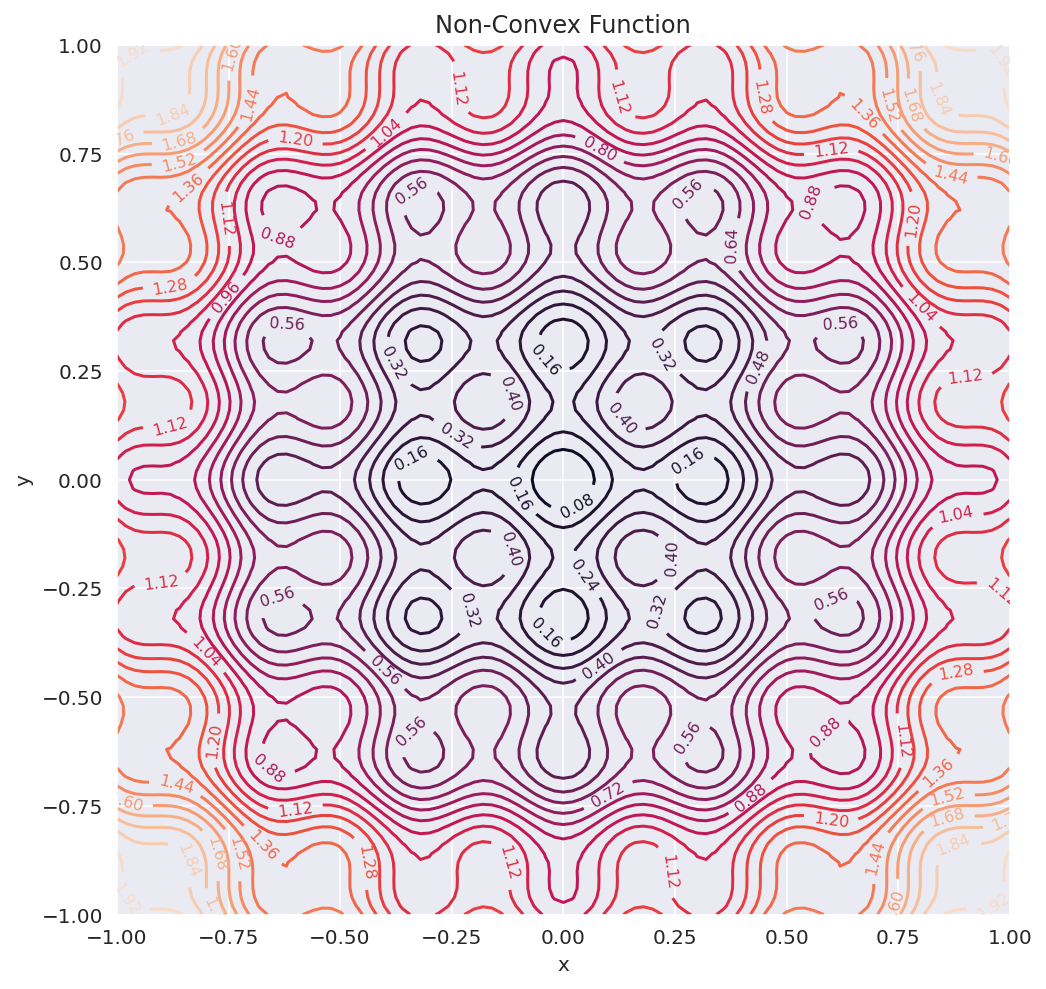

In [13]:
# define objective function and show a contour plot

# note that xy here represents a numpy array with two elements (scalars x and y)
def bumpy(xy):
    # xy can be any length ... the length of xy determines the number of input variables and is called the dimension
    obj = 0.2 + sum(xy**2 - 0.1*np.cos(6*np.pi*xy))
    return obj

# we could have written the objective function like this for transparency:
# if the argument is a list with [ numpy array of x's, numpy array of y's]
# def bumpy(xy):
#     x = xy[0]
#     y = xy[1]
#     obj = 0.2 + x**2 + y**2 - 0.1*np.cos(6*np.pi*x) - 0.1*np.cos(6*np.pi*y)
#     return obj
# see script for details of plot
%run scripts/bumpy_contours.py

Here is a 3D plot that makes it easier to see the local minima in the search space.  A local search will easily get stuck in the wrong minimum if the initial search point isn't very close to the origin.

In [14]:
%run scripts/bumpy_2d.py

To use simulated annealing to optimize a function with continuous variables isn't all that different than how we used it to find a good, or even optimal, tour in the traveling salesman problem.  

We're going to rely on the `simanneal` package in the rest of this lesson because it's much more robust than our "home-brewed" code in the `simanneal_tsp()` function above. 
To use the package we'll have to generate an initial state, define the `energy()` method for returning the objective function value, and define the `move()` method for making a move from a current state to a new state.

To generate an initial state you could select uniformly distributed random numbers between -1 and 1:
```
init_state = np.random.uniform(low=-1, high=1, size=2)
```

We like to write functions for computing the objective function value and for making moves and then call those functions from the `move()` and `energy()` methods in the class definition for our problem as we did in the simanneal package TSP example above.

We already have the objective function from where we made the contour plot:
```
def f(xy):
    obj = 0.2 + sum(xy**2 - 0.1*np.cos(6*np.pi*xy))
    return obj
```

Making a move will consist of applying two functions successively.  The first function adds normally distributed random numbers to each variable while the second function clips values that are out of the $[-1,1]$ bounds.  The scale of the move will need to be passed to the first function, while the values of the lower and upper bounds need to be passed to the clipping function.  These values will need to be initialized in the `__init__` constructor similar to how we worked with the distance matrix in the TSP example.  Here are the functions:
```
def gauss_move(xy,sigma):
    # xy is a 1 by dim numpy array
    # sigma is the standard deviation for the normal distribution
    dim = len(xy)
    return xy + np.random.normal(loc = 0, scale = sigma, size=dim)

def clip_to_bounds(xy,low,high):
    # xy is a 1 by dim numpy array
    # low is the lower bound for clipping variables
    # high is the upper bound for clipping variables
    return np.array( [min(high,max(low,v)) for v in xy])
```

#### *Self-Assessment for Simulated Annealing with Continuous Variables*

Use the objective and move functions from above to create a class using the `simanneal` package.  Use it to approximate the location of the global minimum for the "Bumpy" function above.  You'll notice that you will usually get close to the location of the global minimum at the origin, but it won't be exact because it is very difficult to randomly move exactly to the minimum location.  Typically, for continuous functions, simulated annealing is combined with local search in an iterative procedure (we'll see an example of this in the homework with the `dual_annealing` optimizer from the `scipy.optimize` package.  For this example you could take the best state found by simulated annealing and use it to start a local search using `minimize` from `scipy.optimize` package.

The code from the TSP example above is a good starting point.  Instead of the distance matrix you'll need to pass the scale parameter sigma to determine the size of the moves.  A good starting point for sigma is range/6 where range = upper bound - lower bound.  This value for sigma is because a normal distribution is about 6 * sigma wide.  You may want to experiment with the value of sigma to see how it affects the result of simulated annealing.  You could also play with the time allowed when you set the schedule for the annealing.

### Dual_Annealing from scipy.optimize

Simulated annealing works with both continuous and discrete variables.  For the case of continuous variables the dual_annealing algorithm in the scipy.optimize package tends to work rather well.  It combines simulated annealing for exploration of the search space along with local search to enhance the convergence once a good minimum is found.  It's pretty easy to use and <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.dual_annealing.html">documentation can be found here.</a>. You can also execute the cell below to see the documentation:

In [15]:
# execute for dual_annealing documentation
?dual_annealing

Signature:
dual_annealing(
    func,
    bounds,
    args=(),
    maxiter=1000,
    minimizer_kwargs=None,
    initial_temp=5230.0,
    restart_temp_ratio=2e-05,
    visit=2.62,
    accept=-5.0,
    maxfun=10000000.0,
    seed=None,
    no_local_search=False,
    callback=None,
    x0=None,
)
Docstring:
Find the global minimum of a function using Dual Annealing.

Parameters
----------
func : callable
    The objective function to be minimized. Must be in the form
    ``f(x, *args)``, where ``x`` is the argument in the form of a 1-D array
    and ``args`` is a  tuple of any additional fixed parameters needed to
    completely specify the function.
bounds : sequence or `Bounds`
    Bounds for variables. There are two ways to specify the bounds:

    1. Instance of `Bounds` class.
    2. Sequence of ``(min, max)`` pairs for each element in `x`.

args : tuple, optional
    Any additional fixed parameters needed to completely specify the
    objective function.
maxiter : int, optional
    T

#### Dual_Annealing Applied to "Bumpy"

Try executing the cell below.  Note that you won't get exactly the same answer if you execute the cell repeatedly because of the random nature of simulated annealing.  In any case, the global minimum function value is 0 and occurs at x = 0, y = 0.  Dual_annealing finds this minimum approximately to within its default convergence settings:

In [16]:
def bumpy(xy):
    obj = 0.2 + sum(xy**2 - 0.1*np.cos(6*np.pi*xy))
    return obj

bounds = [(-1,1),(-1,1)] # one tuple for each dimension
res = dual_annealing(bumpy, bounds)

print(f'The minimum value is {res.fun} and occurs at x = {res.x[0]}, y = {res.x[1]}')

print(f'\n{res.nfev} evaluations of the bumpy function were needed.')

The minimum value is 1.1657341758564144e-15 and occurs at x = -4.332260130010697e-09, y = 6.614939618629521e-09

4061 evaluations of the bumpy function were needed.


Notice that the Dual_Annealing algorithm requires many fewer function evaluations than either of the simulated annealing implementations we studied above.  This is because the combination of global and local search is especially efficient.

## Bayesian Optimization

Bayesian Optimization is becoming quite popular in the machine learning world. The big advantage of Bayesian Optimization is that it learns as it goes, and does so more efficiently than just repeatedly solving whatever your objective function is. It does this by using a surrogate function that's generally much less expensive to evaluate than the objective function is, and using the results of that surrogate function to update the sample data and zero in on the optimal solution.  Bayesian Optimization is useful when:
* the objective function is very expensive to evaluate
* the dimensionality of the problem (the number of input variables) is not too large, e.g. $\leq 20$
* the derivative of the objective function is unknown or unavailable (the derivate is a function which reveals the slope of the function)
* you are seeking a global minimum instead of a local minimum.
* the objective function may include noise so that the function does not return the same value every time it is evaluated

We will see that Bayesian Optimization gets used for Hyperparameter Optimization of machine learning models.  Machine learning models can be expensive to evaluate and because they often work with random subsets of the training data they may not produce the same results on every evaluation.

### Bayesian Walkthrough Video 1

In this video we talk through the main ideas in Bayesian Optimization and we go through the notebook sections below "Steps in Bayesian Optimization" through "Putting it Together by Iterating".   There will be two more videos on Bayesian Optimization further below.

In [17]:
# Execute for Video
play_video("ds775_lesson6_bayesian-optimization-overview")

### Steps in Bayesian Optimization

We are going to walk through the steps in Bayesian Optimization below.  We'll implement each step in Python.  Don't worry too much about the exact coding details since we'll ultimately use packages to automate Bayesian Optimization.  Instead, just focus on developing a high-level picture of how Bayesian optimization works.  If you want more details, there are **many** tutorials available with a bit of googling.  <a href="https://towardsdatascience.com/the-beauty-of-bayesian-optimization-explained-in-simple-terms-81f3ee13b10f">This article</a> gives a high-level view and talks a bit about what makes this optimization approach "Bayesian".  The image below illustrates the steps.  It's called "Bayesian" because a Bayesian probability framework is used to show how to update the surrogate model to reflect the knowledge gained from the additional sample point.

<img src="images/BayesianOptimizationFlowChart.png" width = "400" align="center"/>

<br><br>

#### Define your Objective Function and Evaluate on Initial Sampling Set

The first step in any optimization problem is determining your objective function. Bayesian optimization requires an objective function in which your variables have bounds (a finite limit on each real or integer number or a defined set of values for categorical variables). 

For illustration we'll work with an objective function that has one input variable.  Suppose we want to minimize
$$f(\mathbf{x})=x \sin(x) + \epsilon, \mbox{ for } x \in [0,10].$$

$\epsilon$ is a normally distributed random variable with mean 0 and standard deviation $\sigma$ that represents the theoretical noise level.  Setting $\sigma = 0$ gives an ordinary function without added noise.

Here is a graph of the objective function (without noise) to help you visualize:

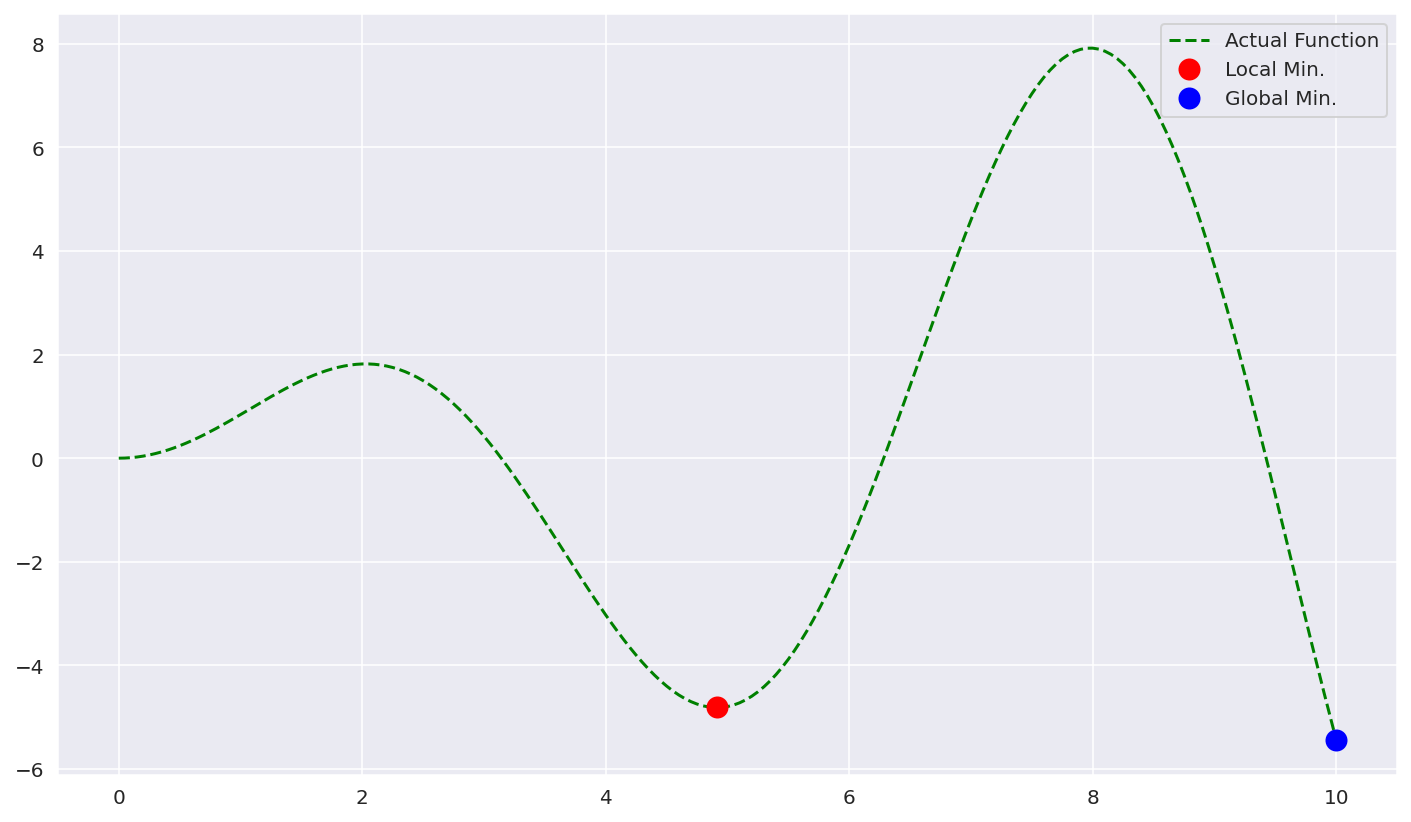

In [18]:
def objective(x, noise_level = 0):
    y = x * np.sin(x) + np.random.normal(loc=0,scale=noise_level)
    return(float(y))

noise = 0
X_plot = np.arange(0,10.05,.05).reshape(-1,1)
y_plot = np.asarray([objective(x, noise) for x in X_plot])
plt.plot(X_plot,y_plot,'g--',label='Actual Function')
plt.plot(4.91,-4.81,'r.',markersize=20,label='Local Min.')
plt.plot(10,-5.44,'b.',markersize=20,label='Global Min.')
plt.legend()

In practice, we don't know the actual function and since it's very expensive to evaluate we only know it at a limited sample of points.  Let's say that we've evaluated the objective function at x = 0,2,4,7,9 to obtain our initial sample of points:

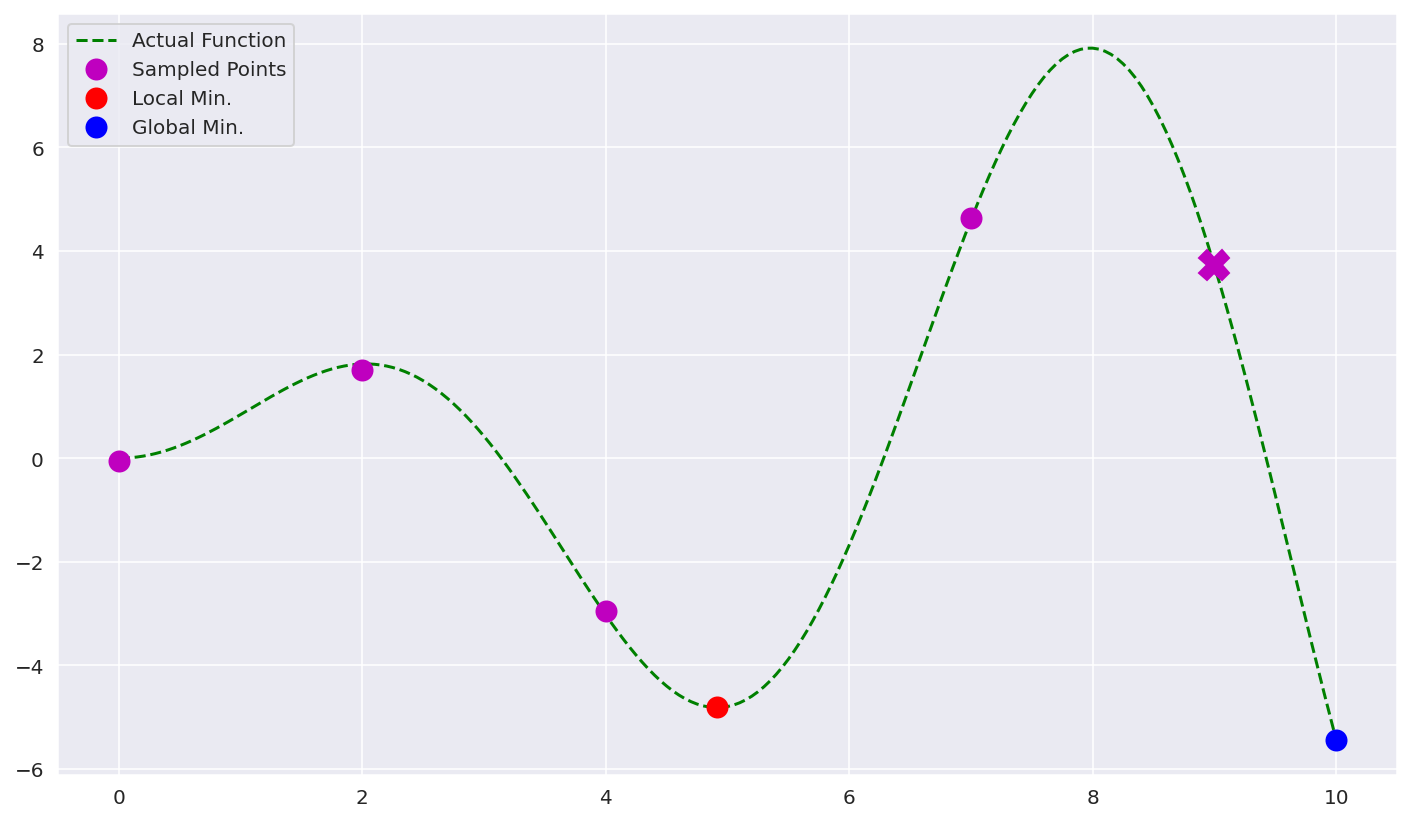

In [19]:
noise = 0
X_plot = np.arange(0,10.05,.05).reshape(-1,1)
y_plot = np.asarray([objective(x, noise) for x in X_plot])
plt.plot(X_plot,y_plot,'g--',label='Actual Function')

noise = 0.1
X_sample = np.asarray([0,2,4,7,9]).reshape(-1,1)
y_sample = np.asarray([objective(x,noise) for x in X_sample]).reshape(-1,1)
plt.plot(X_sample[:-1],y_sample[:-1],'m.',markersize=20,linestyle='',label='Sampled Points')
plt.plot(X_sample[-1],y_sample[-1],'mX',markersize=15,linestyle='')
plt.plot(4.91,-4.81,'r.',markersize=20,label='Local Min.')
plt.plot(10,-5.44,'b.',markersize=20,label='Global Min.')
plt.legend();

The five magenta points are all the information we currently know about the objective function. Note that they don't lie exactly on the graph of the objective function because we've included a bit of noise. We want to use the information from the sampled points to smartly choose another point that will, hopefully, be closer to the global minimum.  We build a model of the function called a surrogate function to help choose that next point.

### Building the Surrogate Function

The idea behind the surrogate is that it will be cheap to evaluate compared to the objective function so that we can use it to select an optimal next point to add to our sample points.  For Bayesian Optimization the surrogate function is usually a Gaussian Process Regressor.  We won't discuss the details of the model here, but it's important to know that in addition to estimating the function values, a Gaussian Process Regressor model also estimates the uncertainty of the function.

We'll use the default parameters for the <a href="https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html">GaussianProcessRegressor</a> for our surrogate function. This function can issue warnings if we don't have a lot of data at a particular part of the distribution we're sampling, so we'll write a wrapper function to supress the warnings, and we'll return the standard deviation, which we'll use in the next step.

Like all predictive models, this model needs to be trained. We'll get to that shortly. For now, let's just define our surrogate function.

In [20]:
# surrogate or approximation for the objective function
def surrogate(X, model):
    # catch any warning generated when making a prediction
    with catch_warnings():

        # ignore generated warnings
        simplefilter("ignore")
        return model.predict(X, return_std=True)

To complete the surrogate function we still need to declare a Gaussian Process Regressor object and fit it to the sample points:

In [21]:
# define the model
model = GaussianProcessRegressor()
# fit the model
model.fit(X_sample, y_sample)

GaussianProcessRegressor()

To visualize we plot the actual function, the surrogate function, the sample points, and an envelope around the surrogate function that extends vertically by one (estimated) standard deviation in each direction.  Notice that the uncertainty is largest when we are far from the sampled points and smallest near the sampled points.

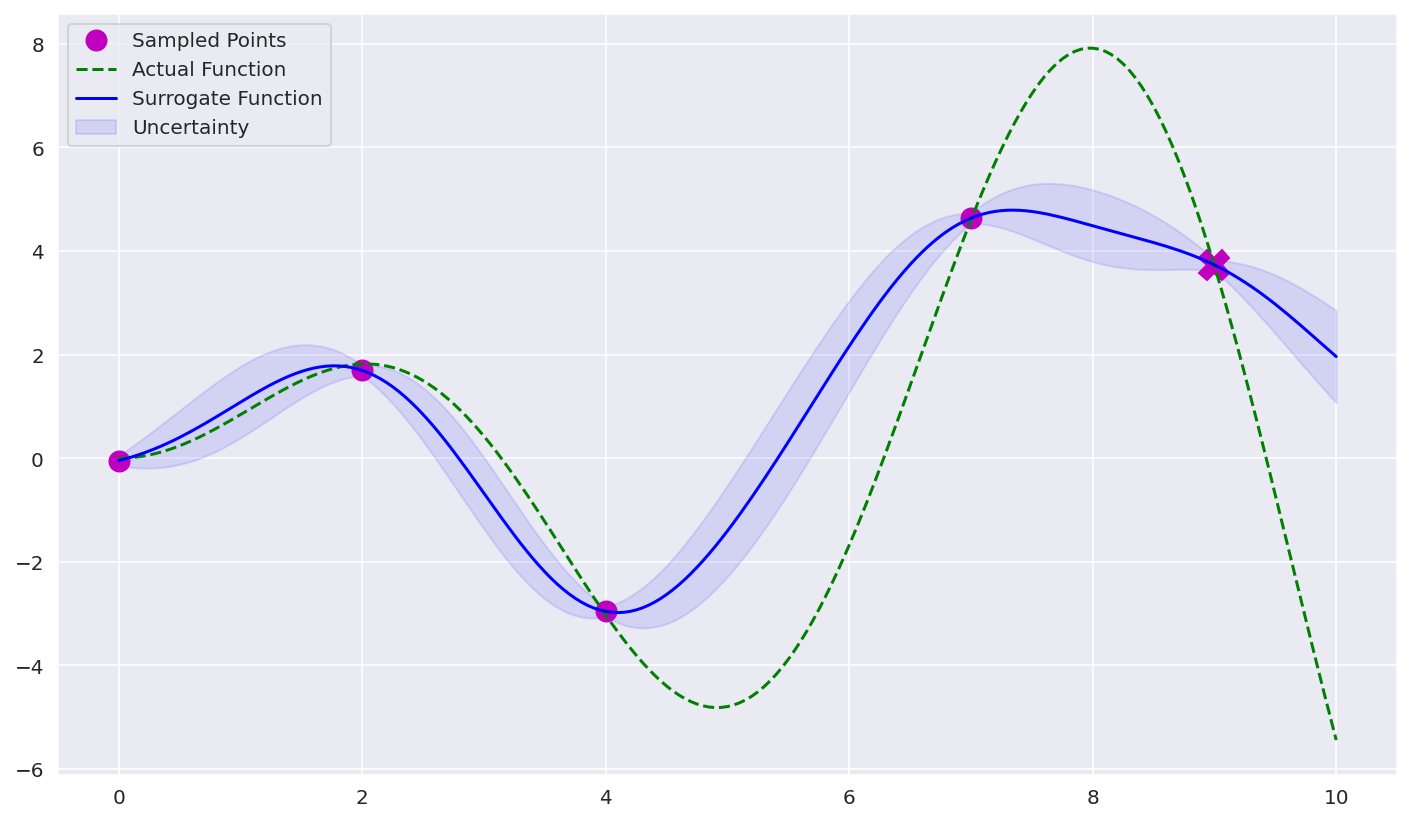

In [22]:
y_surrogate, sd = surrogate(X_plot, model)
y_surrogate = y_surrogate.reshape(-1,1)
sd = sd.reshape(-1,1)

plt.plot(X_sample[:-1],y_sample[:-1],'m.',markersize=20,linestyle='',label='Sampled Points')
plt.plot(X_sample[-1],y_sample[-1],'mX',markersize=15,linestyle='')
plt.plot(X_plot, y_plot,'g--',label='Actual Function')
plt.plot(X_plot, y_surrogate,'b',label='Surrogate Function')
plt.fill_between(X_plot.flatten(),(y_surrogate+sd+noise).flatten(),(y_surrogate-sd-noise).flatten(),color='blue',alpha=0.1,label='Uncertainty')
plt.legend();

### Building the Acquisition Function

From the surrogate model we'd like to identify another point to add to our sample (another magenta point) where we'll evaluate the actual objective function.  To do this we will first construct an acquisition function from the surrogate and then use the acquisition to "acquire" the next point.

Next we need what's called an acquisition function. Remember we said that Bayes Optimization learns as it goes. It does that by "acquiring" new data points. Each iteration of the algorithm will run the surrogate model and then "acquire" the sample point or points that are most likely to improve the overall results. Again, there are many ways to do approach determining what the best new points are. Three common approaches are:

* Probability of Improvement (PI).
* Expected Improvement (EI).
* Lower Confidence Bound (LCB).

We'll demonstrate by building the LCB acquisition function.  The surrogate model returns both the approximate function value as $\mu(x)$ and the expected variability, the standard deviation, as $\sigma(x)$.  The formula for the LCB is
$$a(x) = \mu(x) - \kappa \sigma(x).$$ Essentially, the LCB is found by looking $\kappa$ standard deviations below the surrogate function values.  We won't discuss the other acquisition functions here, but there are many articles that can help <a href="https://distill.pub/2020/bayesian-optimization/">like this one.</a>

Here are two examples.  (We've also defined a helper function for plotting here.)

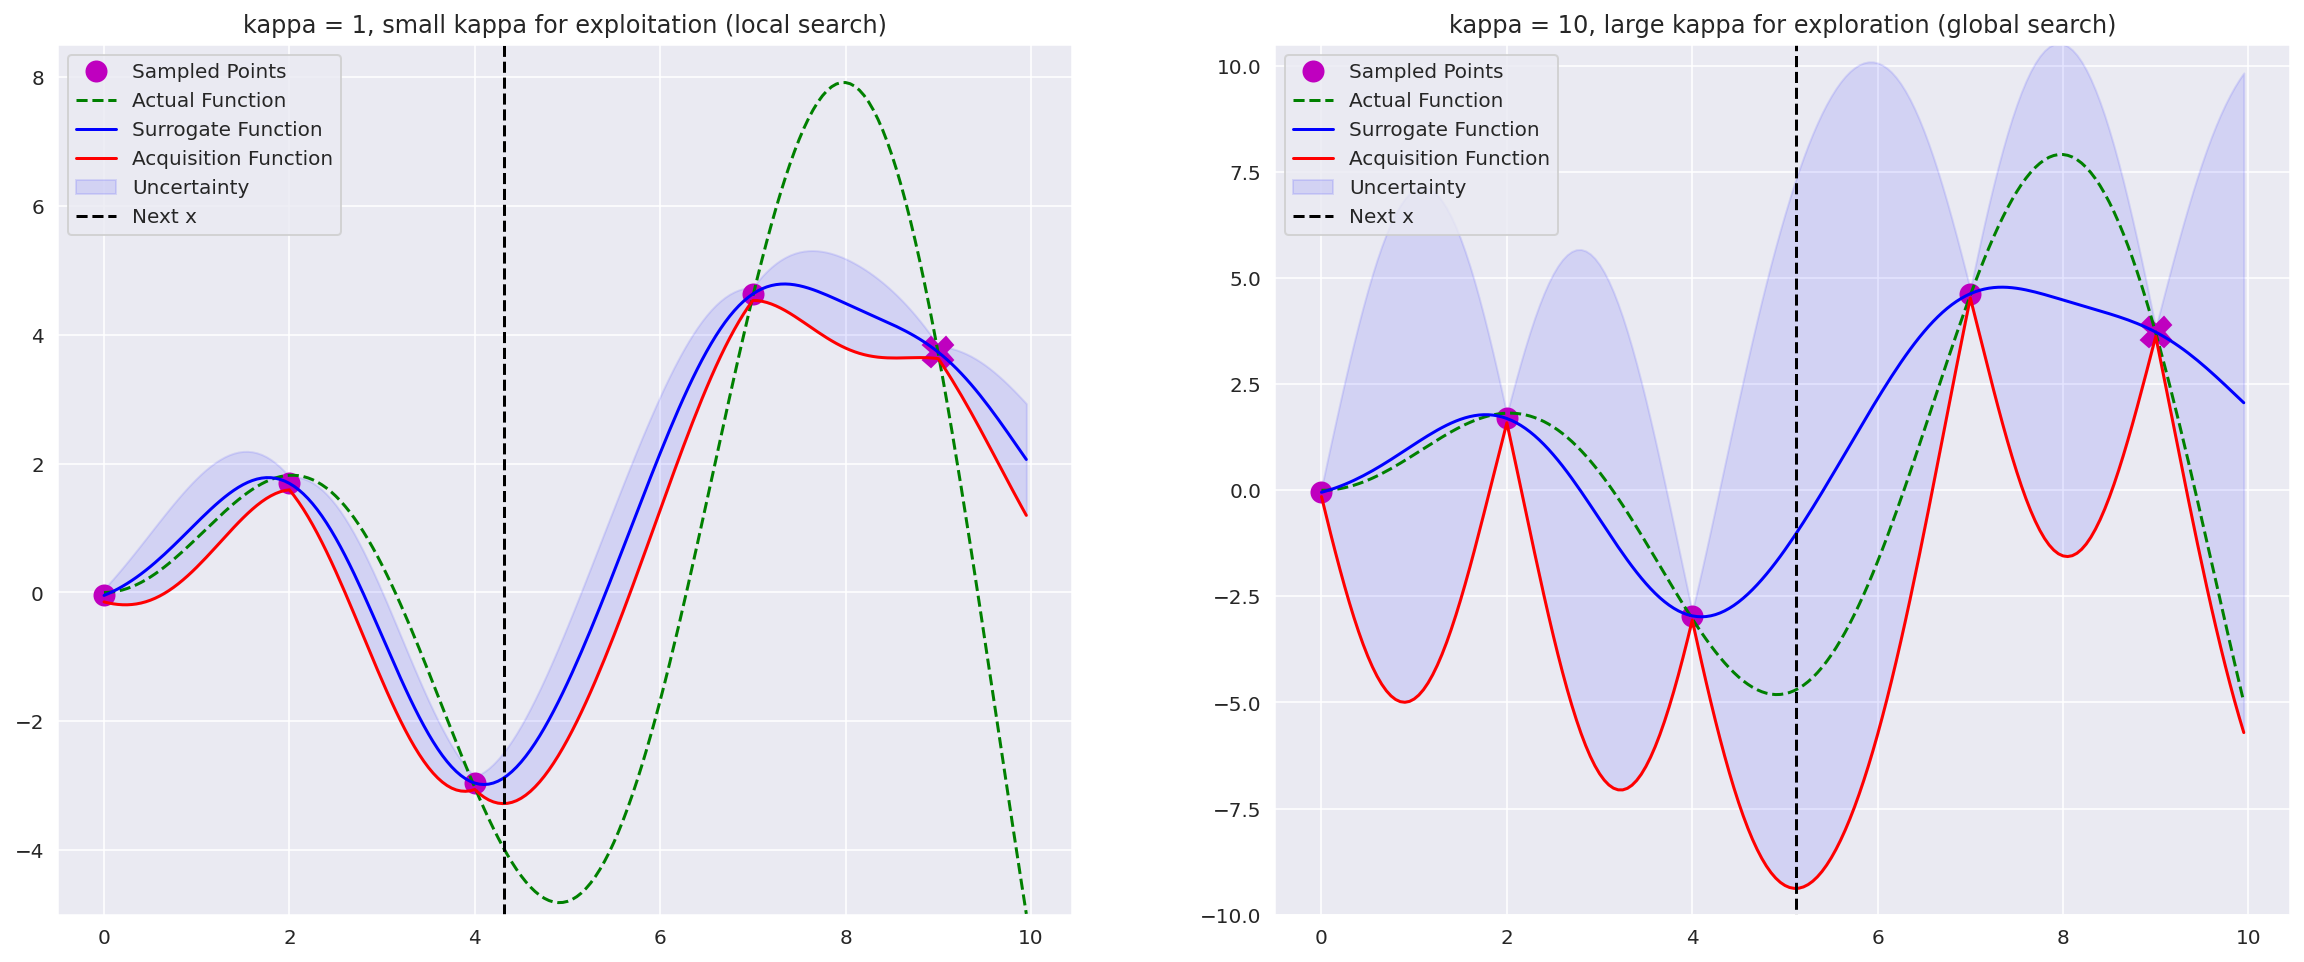

In [23]:
def plot_bayesian_opt(X,y,model,objective,axis,noise = 0, kappa = 1):
    X_plot = np.arange(0,10,.05).reshape(-1,1)
    y_obj = np.asarray([objective(x, noise_level = 0) for x in X_plot]) # no noise for exact eval
    y_surrogate, sd = surrogate(X_plot, model)
    y_surrogate = y_surrogate.reshape(-1,1)
    sd = sd.reshape(-1,1)
    axis.plot(X_sample[:-1],y_sample[:-1],'m.',markersize=20,linestyle='',label='Sampled Points')
    axis.plot(X_sample[-1],y_sample[-1],'mX',markersize=15,linestyle='')
    axis.plot(X_plot, y_obj,'g--',label='Actual Function')
    axis.plot(X_plot, y_surrogate,'b',label='Surrogate Function')
    axis.plot(X_plot, y_surrogate-kappa*sd-noise,'r',label='Acquisition Function')
    axis.fill_between(X_plot.flatten(),(y_surrogate+kappa*sd+noise).flatten(),(y_surrogate-kappa*sd-noise).flatten(),color='blue',alpha=0.1,label='Uncertainty')
    axis.legend()
    
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,8))

ax1.set_title('kappa = 1, small kappa for exploitation (local search)')
plot_bayesian_opt(X_sample,y_sample,model,objective,ax1,noise=0.1,kappa = 1)
ax1.plot([4.32,4.32],[-5,8.5],'k--',label='Next x')
ax1.set_ylim([-5,8.5])
ax1.legend();

ax2.set_title('kappa = 10, large kappa for exploration (global search)')
plot_bayesian_opt(X_sample,y_sample,model,objective,ax2,noise = 0.1,kappa = 10)
ax2.plot([5.12,5.12],[-11,11],'k--',label='Next x')
ax2.set_ylim([-10,10.5])
ax2.legend();

The LCB acquisition function is the red curve at the bottom of the uncertainty envelope.  To acquire the next search point we seek the global minimum of the acquisition function.  Note that when $\kappa = 1$ the acquisition (red) and surrogate function graphs are pretty similar so that when we minimize the acquisition function we get about $x = 4.3$ which is close to the current minimum value at $x = 4.3$. When $\kappa = 10$ the new minimum occurs around $x = 5.1$ because $\kappa = 10$ places more emphasis on the uncertainty in the surrogate model.  The vertical dashed black lines show the location of the next point identified by minimizing the acquisition function.

*Small values of $\kappa$ emphasize local search (exploitation) while large values of $\kappa$ emphasize global search (exploration).*

The next step is to acquire the new point by finding or approximating the minimum of the acquisition function.  Normally we'd let a Bayesian Optimization package handle the details, but we'll show one way to do it for a one-dimensional function here.

In [24]:
def acquisition_fun_lcb(X, model, kappa):
    x2 = np.array(X).reshape(-1,1)
    y,sd = surrogate(x2, model)
    y = y.reshape(-1,1)
    sd = sd.reshape(-1,1)
    out = (y-kappa*sd).flatten()
    return( out )

def acquire_next_point(model, kappa):
    x_grid = np.arange(0,10.01,.01) # check points spaced every 0.01
    y_grid = np.asarray([acquisition_fun_lcb(x,model,kappa) for x in x_grid]).reshape(-1,1)
    min_y_idx = np.argmin(y_grid)
    return x_grid[min_y_idx]

# get next point when kappa = 1
x1 = acquire_next_point(model,1)
print(f'Next sample point with kappa = 1 is {x1:.2f}')

# get next point when kappa = 10
x2 = acquire_next_point(model,10)
print(f'Next sample point with kappa = 10 is {x2:.2f}')

Next sample point with kappa = 1 is 4.31
Next sample point with kappa = 10 is 5.12


The next step would be to find evaluate the actual objective function to get $y$ values for the new sample point and then append the point, $x$ and $y$, to the sample.  Now go back to the model building step and repeat the process until happy.  We'll show what that looks like for a couple of iterations with $\kappa =10.$. The first cell below initializes the sample data and loads the helper functions.  The second cell can be executed repeatedly to perform multiple iterations of Bayesian Optimization.

In [25]:
# reinitialize the sample data to start fresh

noise = 0.1
kappa = 2
X_sample = np.asarray([0,2,4,7,9]).reshape(-1,1)
y_sample = np.asarray([objective(x,noise) for x in X_sample]).reshape(-1,1)

# define and fit the model
model = GaussianProcessRegressor()
model.fit(X_sample, y_sample)

GaussianProcessRegressor()

At this point we've initialized the Gaussian Process regression model using the first five sample points.  

### Putting it Together by Iterating

Each time you execute the next cell you'll complete one iteration of Bayesian optimization that results in new value of $x$ that will be added to the sample (the vertical black dashed line is the location of the next $x$ based on the current data.

New point for sample: (5.11,-4.74)
Smallest function value so far -4.74


GaussianProcessRegressor()

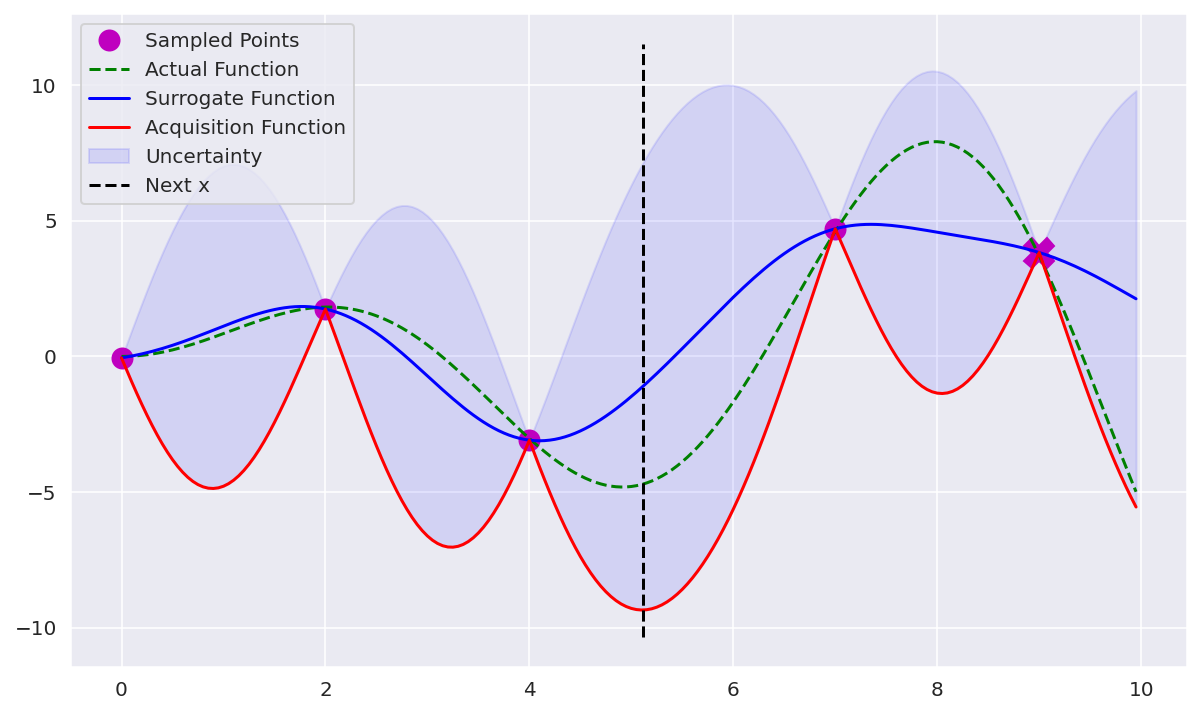

In [26]:
# each time this cell is executed on iteration of Bayesian Optimization occurs up to the point where the new point is selected, 
# on the next iteration it will be plotted
kappa = 10

# get next x coordinate
x = acquire_next_point(model,kappa)

# evaluate objective function to get new y coordinate (includes .1 noise)
y = objective(x, noise_level = noise)

print(f'New point for sample: ({x:0.2f},{y:0.2f})')

# plot to see where next point will be added
fig = plt.figure(figsize = [10,6])
ax = plt.gca()
plot_bayesian_opt(X_sample,y_sample,model,objective,ax,kappa = kappa)
ylim = ax.get_ylim()
ax.plot([x,x],ylim,'k--',label='Next x')
ax.legend()

# now add the point to our sample
X_sample = np.vstack((X_sample, [[x]]))
y_sample = np.vstack((y_sample, [[y]]))

print(f'Smallest function value so far {np.min(y_sample):0.2f}')

# refit the model
model.fit(X_sample,y_sample)

Our from-scratch solution is not the best implementation of this algorithm. But we wanted to include it so that you could really step through each of the pieces.  Instead of continuing forward and writing our own Bayesian Optimization function we'll rely on packages.

There are several packages that implement Bayes Optimization in a much more efficient way. We'll focus on `Scikit-Optimize` since it's designed to work in conjunction `Scikit-Learn` package for machine learning that we'll meet in Lesson 8.


## Bayesian Optimization with `Scikit-Optimize`

The video below describes the material in this section and the next.

In [28]:
# execute for video
play_video("ds775_lesson6_bayesian-optimization-scikit-optimize")

Scikit-Optimize expects that you are minimizing an objective function. 

In [29]:
noise = .1

def objective(x, noise_level = noise):
    y = x * np.sin(x) + np.random.normal(loc=0,scale=noise_level)
    return(float(y))

The function we need to use to run our Bayesian Optimization is <a href="https://scikit-optimize.github.io/stable/modules/generated/skopt.gp_minimize.html">gp_minimize</a>. There are many parameters you can set on this function, so I encourage you to read the documentation to understand all of them. We are only going to set a few:

* the function to minimize (which should return a scalar (single number) value)
* the dimensions that will be searched
* the acquisition function
    * We can also choose from LCB for lower confidence bound, EI for expected improvement, PI for probability of improvement or gp_hedge, which probabilistically chooses from one of the first three options at every iteration. This is the default option. But, we'll switch to LCB, since that's what we were using above.
* the number of evaluations of the objective function (n_calls)

The function returns an "Optimization Result" object that contains the location of the minimum, the function value at the minimum, and several other values. (Don't worry if you see warnings, they seem to be harmless.  We've attempted to suppress the warnings in this section.)

In [30]:
filterwarnings('ignore')

np.random.seed(42) #adding random seed here, too, for the noise factor
#call the optimization.
res = gp_minimize(objective,                  # the function to minimize
                  [(0.0,10.0)],      # the bounds on each dimension of x
                  acq_func="LCB",      # the acquisition function
                  kappa = 10,
                  n_calls=20,         # the number of evaluations of the objective function
                  n_random_starts=5,  # the number of random initialization points
                  random_state=42)   # the random seed

print(f'The minimum value of f(x) is {res.fun:0.4f} and occurs at x={res.x[0]:0.4f}')
print(f'Recall that the objective function may include noise, so the optimized function value may not be exact.')

The minimum value of f(x) is -5.6315 and occurs at x=10.0000
Recall that the objective function may include noise, so the optimized function value may not be exact.


This package also contains some handy plots. Let's plot convergence. This will tell us how quickly the best value was achieved. In this case, we achieved our best result by the 15th iteration.

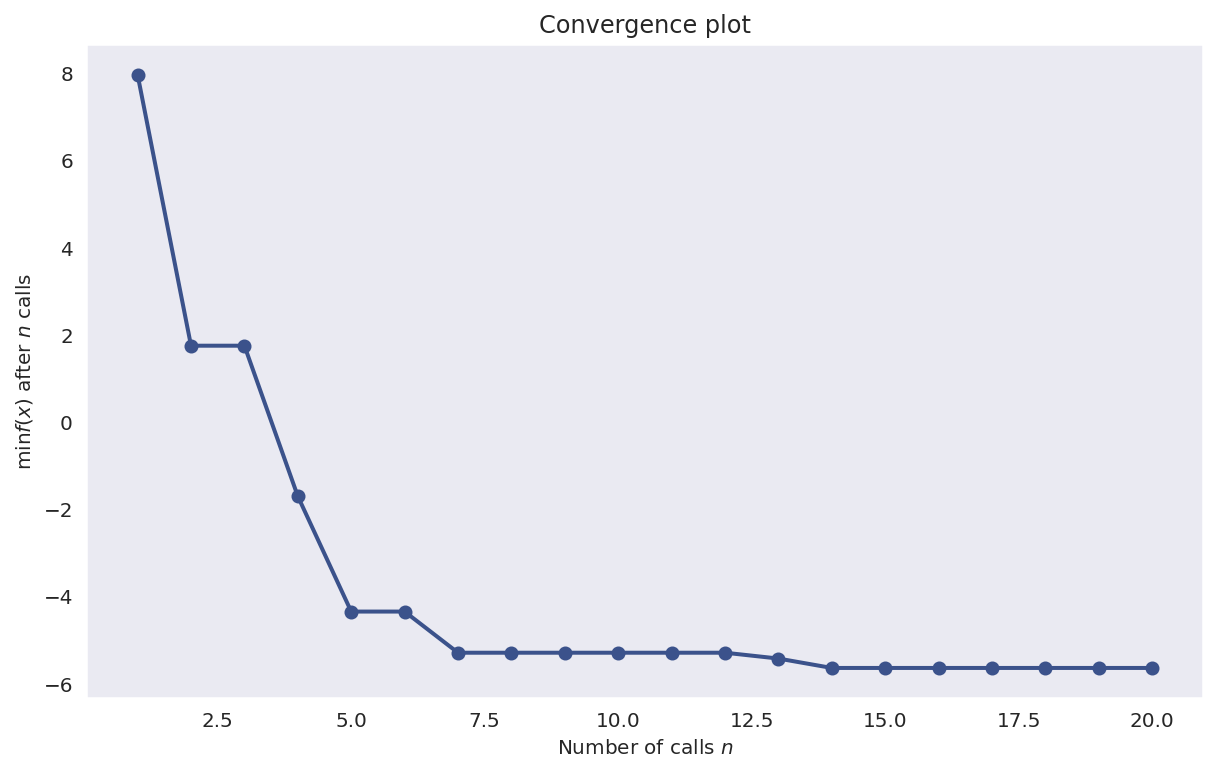

In [31]:
fig = plt.figure(figsize=(10,6)) # we initialize the plot so we can control dimensions
ax = fig.add_axes
plot_convergence(res,ax);

### Bayesian Optimization for Multi-Dimensional Functions

The `gp_minimize` algorithm can handle multi-dimensional functions, as long as what's returned from your objective function is a scalar value. Let's consider the "bumpy" function from our simulated annealing section above.

Find the minimum value of 
$$f(x,y) = 0.2 + x^2 + y^2 - 0.1 \cos(6 \pi x) - 0.1 \cos(6 \pi y)$$ 

for $-1 \leq x,y \leq 1$. 

The bounds for this function are [-1,1] for both x and y, and the global minimum of 0 is at f(0,0). For plots of the "bumpy" function scroll up to the Simulated Annealing section.


The minimum value of f(x) is 0.0000 and occurs at x=0.0000, y=0.0000
Recall that the objective function may include noise, so the optimized function value may not be exact.


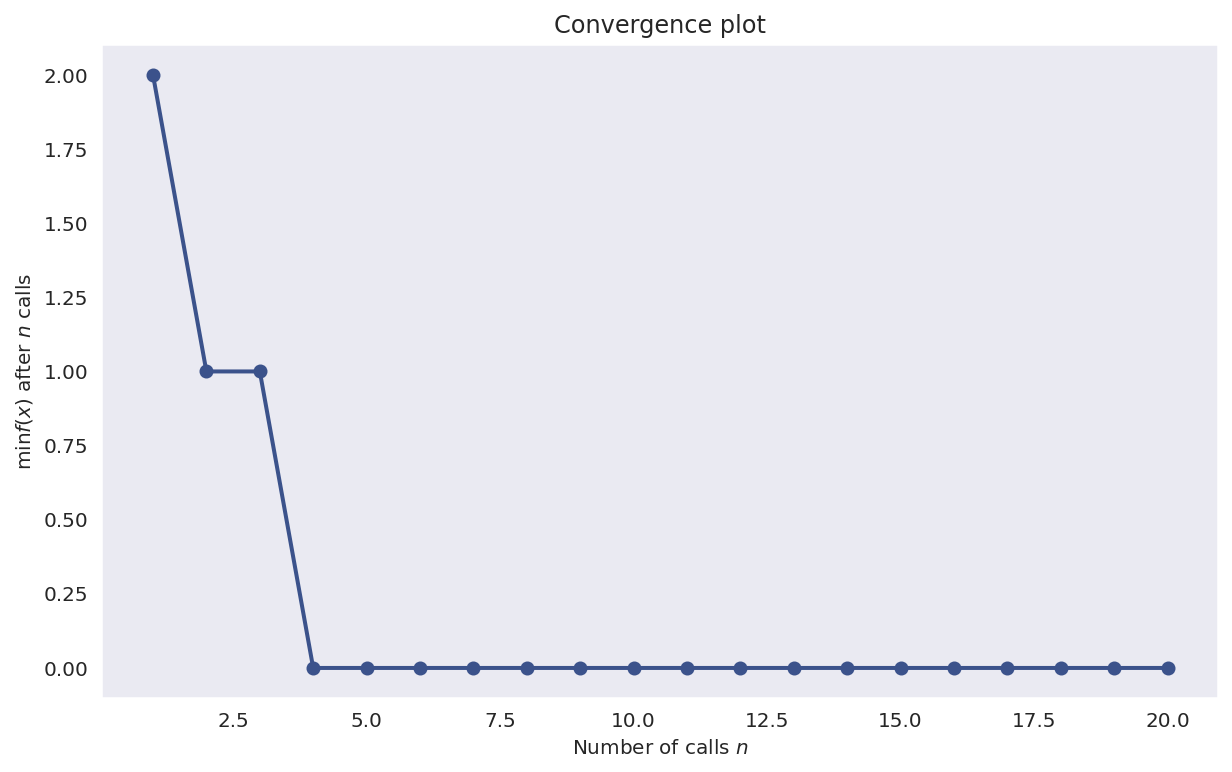

In [32]:
filterwarnings('ignore') # suppress some of the warnings from B.O.

np.random.seed(42)

# same "bumpy" function as in simulated annealing, just written differently
# assumes xy is a list or array-like with xy = [x, y]
def bumpy(xy):
    x = xy[0]
    y = xy[1]
    obj = 0.2 + x**2 + y**2 - 0.1 * np.cos(6*np.pi*x) - 0.1 * np.cos(6*np.pi*y)
    return obj

#call the optimization.
res = gp_minimize(bumpy,                  # the function to minimize
                  [(-1, 1), (-1, 1)],      # the bounds on each dimension of x
                 acq_func="EI",      # the acquisition function 
                  n_calls=20,         # the number of evaluations of the objective function
                  n_random_starts=5,  # the number of random initialization points
                  random_state=42)   # the random seed

print(f'The minimum value of f(x) is {res.fun:0.4f} and occurs at x={res.x[0]:0.4f}, y={res.x[1]:0.4f}')
print(f'Recall that the objective function may include noise, so the optimized function value may not be exact.')

fig = plt.figure(figsize=(10,6)) # we initialize the plot so we can control dimensions
ax = fig.add_axes
plot_convergence(res,ax);

We find it pretty amazing that Bayesian Optimization finds the global optimum so quickly for a function with so many local optima.

#### Self-Assessment - Bayesian Optimization of the Booth function

Use Bayesian Optimization (`gp_minimize`) to estimate the global minimum value of the Booth function, a common optimization test problem:

$f(x,y)=(x+2y-7)^2+(2x+y-5)^2$

for $x$ and $y$ both in [-10,10].

### Tuning Hyperparameters using Bayesian Optimization

**<font color="red">The material in this section is optional but will provide you some background for the Lesson 8 Project on tuning hyperparameters for machine learning models.  There won't be any homework problems for the material in this section.</font>. You may still wish to read the final section below for a summary of Bayesian Optimization.**

This video summarizes the material in this section:

In [33]:
# execute for video
play_video("ds775_lesson6_hyperparameter-tuning")


In machine learning the predictive models must be trained to give predictions that match the data as well as possible.  Each model has both parameters and hyperparameters.  Parameters are coefficients in the model that are determined directly from the data.  Hyperparameters are values that affect the model but aren't determined directly from the data.  Normally they are supplied by the scientist and sometimes tuned to produce a better fit.

Regression models often include regularization terms that help prevent the model from overfitting (memorizing) the data instead of capturing the underlying trend.  We won't talk about the details of regularization here, but it's discussed in the DS740 class (<a href="https://towardsdatascience.com/the-basics-logistic-regression-and-regularization-828b0d2d206c">here's an article if you really want to explore more</a>).  The strength of the regularization is inversely proportional to a constant $C$ (regularization $\sim 1/C$).  So when C is large there is very little regularization, but when $C$ is small the regularization is large which forces the logistic regression model to depend mostly on only the important predictor variables.  We're going to consider $C = 10^p$ so positive $p$ corresponds to large $C$ and negative $p$ corresponds to small values of $C$.  The value of $C$ (or $p$) is not determined by the data but must be specified.  Below, we'll show an example of using Bayesian Optimization to determine an optimal value of $C$ to maximize model accuracy.  You'll be doing much more of this in Lesson 8 so don't worry too much about the details here.

#### Predicting Iris Species

In the classic Iris dataset we have a four predictor variables corresponding to physical measurements of the iris and a single categorical variable that is species of the iris.  Three species are possible.  If you've never seen this data before or want to review some logistic regression then <a href="https://randerson112358.medium.com/python-logistic-regression-program-5e1b32f964db">here is a short article that may help.</a>

To get an idea how logistic regression works here we'll load the data, train a model using the default hyperparameter values, and display the confusion matrix.  We've increased the maximum iterations for the Logisitic Regression model fit to help with convergence.

In [34]:
X = np.array([i for i in range(30)]).reshape(-1,1)

X, y = load_iris(return_X_y=True)

logreg=LogisticRegression(max_iter=500)

logreg.fit(X,y)
y_pred = logreg.predict(X)

confusion_matrix(y,y_pred)

array([[50,  0,  0],
       [ 0, 47,  3],
       [ 0,  1, 49]])

If the classification were perfect there would be 50's along the diagonal and zeros elsewhere.  This confusion matrix indicates that four of the 150 irises were misclassified.  The accuracy is $146/150 = 97.3\%.$. Now we'll see if we can maximize the accuracy by using Bayesian Optimization to optimize the value of the regularization parameter $C$.  Instead of optimizing $C$ directly, we'll actually optimize $p$ and set $C = 10^p$.  This is because for many small parameters it makes sense to try values like $10^{-4}, 10^{-3}, 10^{-2}, \ldots$ instead of $0.1, 0.2, 0.3, \ldots$ (this <a href="https://stats.stackexchange.com/questions/291552/why-do-we-sample-from-log-space-when-optimizing-learning-rate-regularization-p">Stackexchange post</a> explains it nicely). The accuracy is estimated by finding the average accuracy after 10-fold cross validation.  Note, we've defined our function to return the negative average accuracy for the purpose of maximization a bit later.

In [35]:
def estimated_accuracy(p,X,y):
    logreg = LogisticRegression(C=10.0**p, max_iter = 500 )
    means = cross_val_score( logreg, X, y, cv = 10, scoring = 'accuracy')
    return -np.mean(means)

The estimated accuracy when $C=1$ (this is $p=0$ and is the default value) is:

In [36]:
-estimated_accuracy(0, X, y)

0.9733333333333334

Let's see how the estimated accuracy varies as $p$ changes.  We'll consider $ -2 \leq p \leq 2$ corresponding to $ 0.01 \leq C \leq 100.$. 

In [37]:
# this takes a second since 50*10 = 500 models are being trained
num_plot_points = 50
p_exp = np.linspace(-2,2,num=num_plot_points,endpoint=True)
est_acc = np.array([-estimated_accuracy(p,X,y) for p in p_exp])

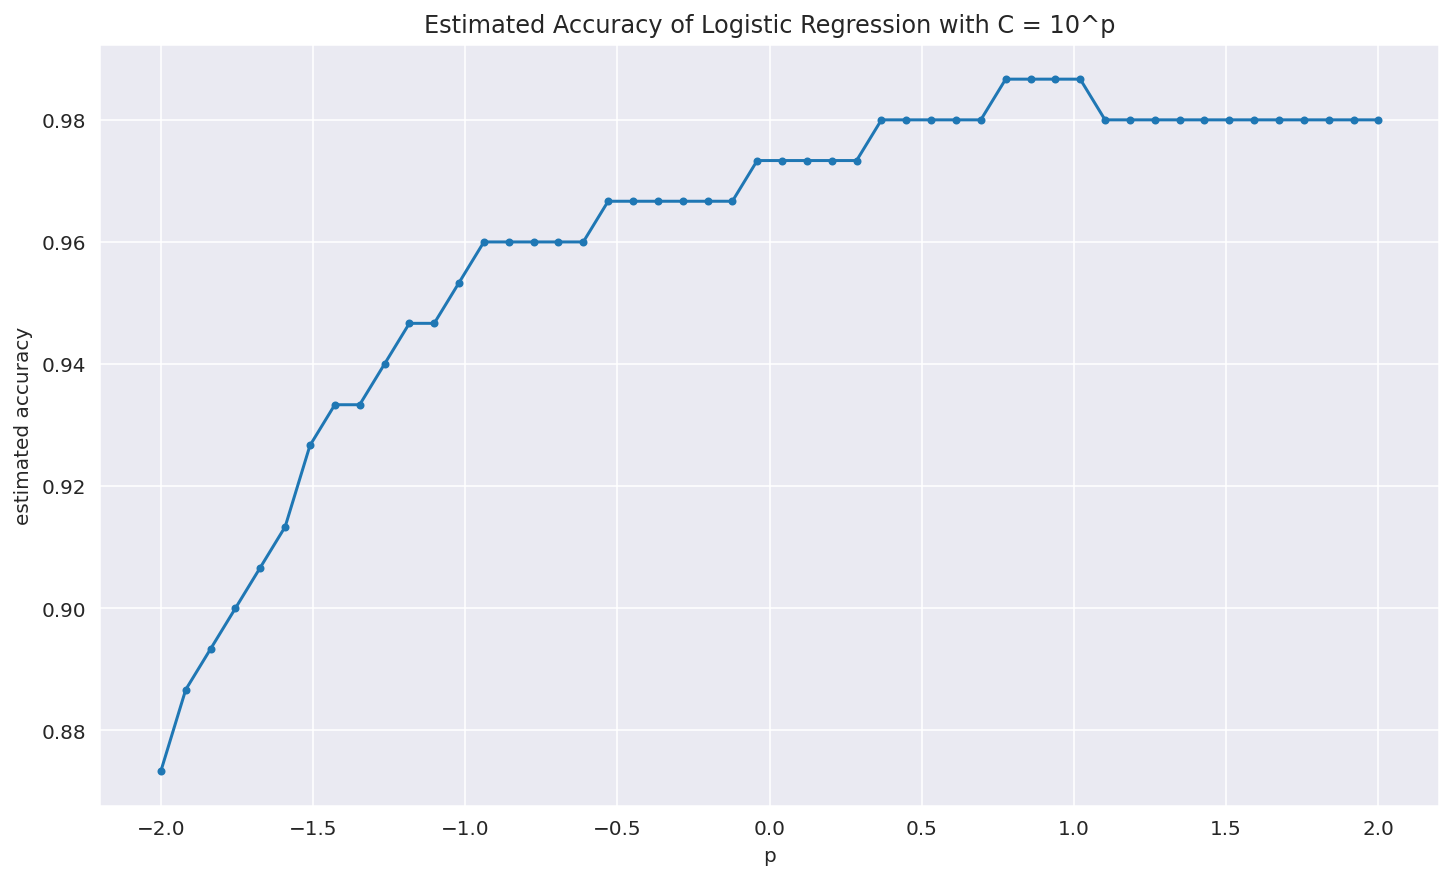

In [38]:
# make the plot
plt.plot(p_exp,est_acc,'.-')
plt.xlabel('p')
plt.ylabel('estimated accuracy')
plt.title('Estimated Accuracy of Logistic Regression with C = 10^p');

It appears that the maximum estimated accuracy occurs around $p \approx 1$ or $C \approx 10^p = 10^1 =10$. We'll minimize the negative accuracy, using `gp_minimize` to find the maximum estimated accuracy and the value of $p$ for which it occurs.  If you haven't studied machine learning yet all you really need to understand is that to tune the hyperparameters we need to optimize a function (`estimated_accuracy`) of the hyperparameters.

The maximum accuracy is about 98.67%
Max accuracy occurs when p = 1.00 or C = 10^p = 10.00


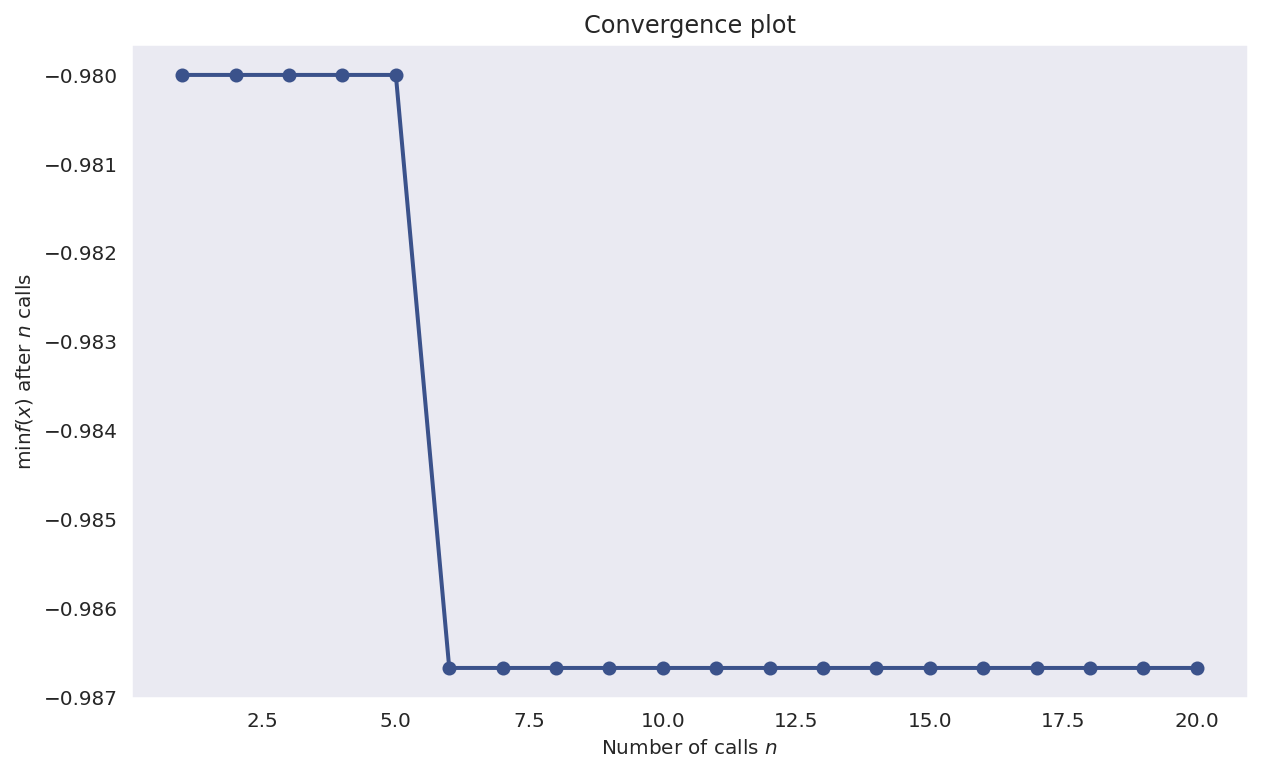

In [39]:
# define a lambda function that includes X,y to be passed to gp_minimize
est_acc = lambda p:estimated_accuracy(float(p[0]),X,y)

res = gp_minimize(est_acc,      # the function to minimize
                  [(-2,2)],                # the bounds on each dimension of x
                  acq_func="EI",            # the acquisition function - using Expected Improvement
                  n_calls=20,         # the number of evaluations of the objective function
                  n_random_starts=5,  # the number of random initialization points
                  random_state=38) # the random seed

print(f'The maximum accuracy is about {-100*res.fun:0.2f}%')
print(f'Max accuracy occurs when p = {res.x[0]:0.2f} or C = 10^p = {10**res.x[0]:0.2f}')
      
fig = plt.figure(figsize=(10,6)) # we initialize the plot so we can control dimensions
ax = fig.add_axes
plot_convergence(res,ax);

In the plot above we're showing negative accuracy, so more negative is good.  Let's look at the confusion matrix with the optimized parameter.

In [40]:
logreg=LogisticRegression(max_iter=500, C = 10.0)

logreg.fit(X,y)
y_pred = logreg.predict(X)

confusion_matrix(y,y_pred)

array([[50,  0,  0],
       [ 0, 48,  2],
       [ 0,  1, 49]])

While there is not a dramatic difference we can see from the confusion matrix that one more observation was classified correctly than before, so optimizing the hyperparameter produced a small benefit here.  Sometimes hyperparameter optimization can make the difference between a good model and a bad one.  There is one homework problem where we'll have you optimize a parameter for a Ridge Regression (Linear Regression with overfitting penalty), but we'll explore hyperparameter optimization further in Lesson 8.

## Some Final Notes on Bayesian Optimization

Bayesian Optimization is expensive and should only be used if 

* the objective function is very expensive to evaluate
* the dimensionality of the problem (the number of input variables) is not too large, e.g. $\leq 20$
* the derivative of the objective function is unknown or unavailable (the derivate is a function which reveals the slope of the function)
* you are seeking a global minimum instead of a local minimum.
* the objective function may include noise so that the function does not return the same value every time it is evaluated

If your objective function doesn't meet those conditions, then there are probably better optimization methods available like simulated annealing or genetic algorithms (next lesson).

Bayesian Optimization can also be extended to accommodate discrete (integer) and categorical decision variables.  We won't study those extensions here, but we'll seem then in Lesson 8 where we'll see how Bayesian Optimization is used to optimize the hyperparameters of machine learning models.  We'll see a lot more about this in the Lesson 8 Project.

The animated gif below is kind of fun and illustrates Bayesian Optimization for a maximization problem with two decision variables.  Notice how the surrogate function (the Gaussian Process mean) becomes more and more like the actual function as sampling points are added.
<br>

<img src="./images/bayesian_optimization.gif" width = "1000">

This animated gif is from this <a href="https://github.com/fmfn/BayesianOptimization">Bayesian Optimization repository on Github</a>. We haven't tried the Bayesian Optimizer in that repository, but it looks like it could be pretty good.

Interestingly, the best model fit occurs when $\alpha = 0.1$, but the default value of $\alpha$ is 1.0.